
## Import all the required libraries

In [27]:
import csv
import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from xgboost import XGBClassifier
import sklearn as s
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

## Import the data

In [3]:
takehome_user_engagement = pd.read_csv("C:\\Users\\Ashlesh B Shetty\\Google Drive\\LaptopOnDrive\\JobSearch\\JobApplications\\Asana\Data\\takehome_user_engagement.csv",
                                       parse_dates = True,                                       
                                       infer_datetime_format = True )
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])
takehome_user_engagement['user_id'] = takehome_user_engagement['user_id'].map(str)
takehome_user_engagement['visited'] = takehome_user_engagement['visited'].map(int)

with open('C:\\Users\\Ashlesh B Shetty\\Google Drive\\LaptopOnDrive\\JobSearch\\JobApplications\\Asana\\Data\\takehome_users.csv', 
          ) as data_file:
    user_data = csv.DictReader(data_file)
    dict_user_data_list = [] 
    for i in user_data:
        dict_user_data_list.append(i)
takehome_users = pd.DataFrame.from_dict(dict_user_data_list)
takehome_users['last_session_creation_time'] = pd.to_datetime(takehome_users['last_session_creation_time'], unit = 's')
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time'])
takehome_users['object_id'] = takehome_users['object_id'].map(str)

## View and check  whether the data has been imported correctly

In [5]:
print(takehome_user_engagement.shape)
print('\n')
print(takehome_user_engagement.describe( include='all'))
print('\n')
takehome_user_engagement.info()
print('\n')
takehome_user_engagement.head()

(207917, 3)


                 time_stamp user_id   visited
count                207917  207917  207917.0
unique               207220    8823       NaN
top     2014-02-05 03:09:54    3623       NaN
freq                      2     606       NaN
first   2012-05-31 08:20:06     NaN       NaN
last    2014-06-06 14:58:50     NaN       NaN
mean                    NaN     NaN       1.0
std                     NaN     NaN       0.0
min                     NaN     NaN       1.0
25%                     NaN     NaN       1.0
50%                     NaN     NaN       1.0
75%                     NaN     NaN       1.0
max                     NaN     NaN       1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null object
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.8+ MB




,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
print(takehome_users.shape)
print('\n')
print(takehome_users.describe())
print('\n')
print(takehome_users.info())
print('\n')
takehome_users.head()


(12000, 10)


       object_id        creation_time             name               email  \
count      12000                12000            12000               12000   
unique     12000                11996            11355               11980   
top         4586  2014-02-11 17:57:53  Araujo Gabriela  JacobTye@gmail.com   
freq           1                    2                5                   2   
first        NaN  2012-05-31 00:43:27              NaN                 NaN   
last         NaN  2014-05-30 23:59:19              NaN                 NaN   

       creation_source last_session_creation_time opted_in_to_mailing_list  \
count            12000                       8823                    12000   
unique               5                       8821                        2   
top         ORG_INVITE        2014-06-04 21:21:37                        0   
freq              4254                          2                     9006   
first              NaN        2012-05-31 08:20:06

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240


## Identify Adopted user And Non Adopted User from the takehome_user_engagement
* Identify the week when these users adopted so all the data for these useres post that shouldnt be considered

In [7]:
takehome_user_engagement['date'] = takehome_user_engagement['time_stamp'].dt.normalize()
#aggregate to day level
thuse_day = takehome_user_engagement.groupby(['date','user_id']).agg({ 'visited': 'sum'}).reset_index()
#aggregate to user_id level
thuse_user = thuse_day.groupby(['user_id']).sum().reset_index()

#checking wether all userid in engagement table is present in user table
print('all userid in engagement table are is user table')
print(thuse_user.shape)
print(takehome_users[takehome_users['object_id'].isin(thuse_user['user_id'].tolist())].shape)

#check the distribution of count of engagenent per user
print("\nonly 30% of the user engage more than once")
print(thuse_user.quantile([0,.2,.3,.4,.5,.6,.7,.71,.8,.9,1]))

all userid in engagement table are is user table
(8823, 2)
(8823, 10)

only 30% of the user engage more than once
      visited
0.00      1.0
0.20      1.0
0.30      1.0
0.40      1.0
0.50      1.0
0.60      1.0
0.70      1.0
0.71      2.0
0.80      5.0
0.90     53.0
1.00    606.0


In [8]:
#let us find all those users who are adopted user and the date they first became adopteduser
thuse_day = thuse_day.set_index('date',drop = False)
thuse_day  = thuse_day.sort_values(by = ['user_id','date'])
thuse_day.index.is_all_dates
adopted_users_fl = thuse_day.groupby(['user_id'])['visited'].rolling( '7D', min_periods = 1).sum().reset_index()
adopted_users = adopted_users_fl[adopted_users_fl['visited'] == 3].drop_duplicates(subset=['user_id', 'visited'],
                                                                                   keep = 'first')

In [9]:
print(adopted_users.shape)
adopted_users.head(3)

(1602, 3)


,user_id,date,visited
8,10,2013-02-19,3.0
294,10002,2014-05-25,3.0
306,10006,2014-03-29,3.0


## adopted users' engagement data filtered till the day before they became adopted users

In [10]:
thuse_day_adopt = adopted_users_fl.merge(adopted_users , how = 'left',on = ['user_id'])
thuse_day_adopt1= thuse_day_adopt[~ ((thuse_day_adopt['visited_y'] == 3) & 
                                     ( thuse_day_adopt['date_x'] >= thuse_day_adopt['date_y']))]
thuse_day_adopt1.head(10)

,user_id,date_x,visited_x,date_y,visited_y
0,1,2014-04-22,1.0,NaT,NaN
1,10,2013-01-16,1.0,2013-02-19,3.0
2,10,2013-01-22,2.0,2013-02-19,3.0
3,10,2013-01-30,1.0,2013-02-19,3.0
4,10,2013-02-04,2.0,2013-02-19,3.0
5,10,2013-02-06,2.0,2013-02-19,3.0
6,10,2013-02-14,1.0,2013-02-19,3.0
7,10,2013-02-17,2.0,2013-02-19,3.0
285,100,2013-06-17,1.0,NaT,NaN
286,10000,2014-05-03,1.0,NaT,NaN


## Calculate all good and simple featues that can be extracted from engagement table

In [11]:
thuse_day_adopt1['visit_twiceperweek'] = np.where(thuse_day_adopt1['visited_x'] ==2.0, 1.0, 0.0)
thuse_day_adopt1['joining_date'] = thuse_day_adopt1.groupby(['user_id'])['date_x'].transform(np.min)
thuse_day_adopt1['first_week_fl'] = np.where(thuse_day_adopt1['date_x'] < 
                                             (thuse_day_adopt1['joining_date'] + pd.Timedelta('7D')),1,0)
thuse_day_adopt2 = thuse_day_adopt1.groupby(['user_id']).agg({'date_x' : ['min','max','count'],
                                          'visit_twiceperweek' : ['sum'],
                                          'visited_y': ['sum'],
                                           'first_week_fl':['sum']}).reset_index()
thuse_day_adopt2.columns = ["_".join(i) for i in thuse_day_adopt2.columns.ravel()]
thuse_day_adopt2['engag_period_days'] = (thuse_day_adopt2['date_x_max'] - 
                                          thuse_day_adopt2['date_x_min'] + 
                                          pd.Timedelta('1D'))/pd.Timedelta('1D')
thuse_day_adopt2['adopteduser_fl'] = np.where(thuse_day_adopt2['visited_y_sum'] > 0.0,1,0)
thuse_day_adopt2['engagement_perweek'] = np.where( thuse_day_adopt2['engag_period_days'] <=7,
                                                 0,
                                               thuse_day_adopt2['date_x_count'] / (thuse_day_adopt2['engag_period_days']/7))

thuse_day_adopt2.rename(columns = {'date_x_count':'engagement_count',
                         'visit_twiceperweek_sum':'weekssecondeng_count',
                                  'first_week_fl_sum': 'firstweek_engcount'}, inplace=True) 
engagement_features = thuse_day_adopt2[['user_id_','firstweek_engcount',
                                        'weekssecondeng_count','engagement_perweek' ,'adopteduser_fl']]
engagement_features.head(15)
# thuse_day_adopt2.head()

C:\Users\Ashlesh B Shetty\Anaconda2\envs\starterbot\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ashlesh B Shetty\Anaconda2\envs\starterbot\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ashlesh B Shetty\Anaconda2\envs\starterbot\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,user_id_,firstweek_engcount,weekssecondeng_count,engagement_perweek,adopteduser_fl
0,1,1,0.0,0.000000,0
1,10,2,4.0,1.484848,1
2,100,1,0.0,0.000000,0
3,10000,2,1.0,0.000000,0
4,10002,2,2.0,0.617647,1
5,10003,2,2.0,0.666667,0
6,10004,1,0.0,0.000000,0
7,10005,1,0.0,0.000000,0
8,10006,1,1.0,0.600000,1
9,10007,1,0.0,0.000000,0


## Calculate all good and simple featues that can be extracted from user table

In [77]:

takehome_users.head()
takehome_users['org_id_fl'] = np.where(takehome_users['org_id']=='0',1,0)
takehome_users['invited_by_user_fl'] = np.where(takehome_users['invited_by_user_id']=='',1,0)
takehome_users['month_fl'] = pd.DatetimeIndex(takehome_users['creation_time']).month
takehome_users['email_domain'] = takehome_users['email'].str.split('@').str[1]
takehome_users['email_domain'] = takehome_users['email_domain'].str.replace('.','_')
takehome_users['non_generalpurpose_emaildomain']=np.where(~(takehome_users['email_domain'].isin(['gmail_com', 
                                                                                  'yahoo_com',
                                                                                  'hotmail_com'])),1 ,0)
user_features = takehome_users[['object_id','creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
                               'org_id_fl','invited_by_user_fl','month_fl','non_generalpurpose_emaildomain']]
user_features.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_fl,invited_by_user_fl,month_fl,non_generalpurpose_emaildomain
0,1,GUEST_INVITE,1,0,0,0,4,0
1,2,ORG_INVITE,0,0,0,0,11,1
2,3,ORG_INVITE,0,0,0,0,3,1
3,4,GUEST_INVITE,0,0,0,0,5,0
4,5,GUEST_INVITE,0,0,0,0,1,0


## Creation of master data

In [13]:
print(engagement_features.shape)
print(user_features.shape)
master_data1 = engagement_features.merge(user_features, how = 'inner', left_on = ['user_id_'],right_on = ['object_id'])
print(master_data1.shape)
master_data1['opted_in_to_mailing_list'] =  master_data1['opted_in_to_mailing_list'].map(int)
master_data1['enabled_for_marketing_drip']= master_data1['enabled_for_marketing_drip'].map(int)
master_data1.head()

(8823, 5)
(12000, 8)
(8823, 13)


,user_id_,firstweek_engcount,weekssecondeng_count,engagement_perweek,adopteduser_fl,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_fl,invited_by_user_fl,month_fl,non_generalpurpose_emaildomain
0,1,1,0.0,0.000000,0,1,GUEST_INVITE,1,0,0,0,4,0
1,10,2,4.0,1.484848,1,10,ORG_INVITE,1,1,0,0,1,1
2,100,1,0.0,0.000000,0,100,ORG_INVITE,0,0,0,0,6,1
3,10000,2,1.0,0.000000,0,10000,ORG_INVITE,1,1,0,0,5,0
4,10002,2,2.0,0.617647,1,10002,SIGNUP,0,0,0,1,3,0


## Basic Highlevel EDA and Hypothesis testing

### Hypothesis1:	During the first week of engagement (i.e. the trial and evaluation stage of the adoption process) users with higher engagement have significantly different adoption patterns

firstweek_engcount  adopteduser_fl
1                   0                 6920
                    1                 1011
2                   0                  301
                    1                  591
dtype: int64


(1541.2617433601531, 0.0, 1, array([[ 6490.96123767,   730.03876233],
        [ 1440.03876233,   161.96123767]]))

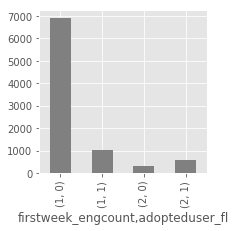

In [72]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['firstweek_engcount','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'firstweek_engcount', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

### Hypothesis2:	During the pre-adoption phase (i.e. the users who have crossed the trial and evaluation stage of the adoption process) users with high frequency weekly engagement have significantly different adoption pattern 

adopteduser_fl
0    0.113907
1    0.813694
Name: engagement_perweek, dtype: float64
Optimization terminated successfully.
         Current function value: 0.687466
         Iterations 4

 parameter
0.423239082784

 pvalue
1.22008079975e-22


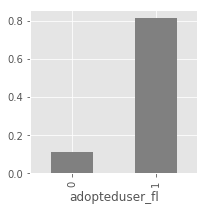

In [105]:
# Look at distribution wrt dependent
variable_summary = master_data1.groupby(['adopteduser_fl'])['engagement_perweek'].mean()
print(variable_summary)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
variable_summary.plot('bar',color = 'grey')

reg_test = sm.Logit(master_data1['adopteduser_fl'],master_data1['engagement_perweek'])
reg_test_results = reg_test.fit()

print('\n parameter')
print(reg_test_results.params.values[0])

print('\n pvalue')
print(reg_test_results.pvalues.values[0])

### Hypothesis3: Users who are having high number of second engagements in a week duration have significantly different adoption pattern

adopteduser_fl
0    0.138208
1    2.548065
Name: weekssecondeng_count, dtype: float64
Optimization terminated successfully.
         Current function value: 0.657684
         Iterations 6

 parameter
0.47979379463

 pvalue
5.91729655458e-93


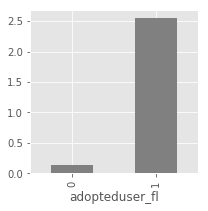

In [106]:
# Look at distribution wrt dependent
variable_summary = master_data1.groupby(['adopteduser_fl'])['weekssecondeng_count'].mean()
print(variable_summary)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
variable_summary.plot('bar',color = 'grey')

reg_test = sm.Logit(master_data1['adopteduser_fl'],master_data1['weekssecondeng_count'])
reg_test_results = reg_test.fit()

print('\n parameter')
print(reg_test_results.params.values[0])

print('\n pvalue')
print(reg_test_results.pvalues.values[0])

### Hypothesis4: Users who show special interest (i.e. who have opted to mailing list or  enabled for marketing drip) have significantly different adoption pattern

opted_in_to_mailing_list  adopteduser_fl
0                         0                 5409
                          1                 1188
1                         0                 1812
                          1                  414
dtype: int64


(0.35143608318966202,
 0.55330132184724667,
 1,
 array([[ 5399.17681061,  1821.82318939],
        [ 1197.82318939,   404.17681061]]))

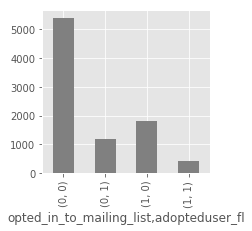

In [75]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['opted_in_to_mailing_list','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'opted_in_to_mailing_list', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

enabled_for_marketing_drip  adopteduser_fl
0                           0                 6126
                            1                 1356
1                           0                 1095
                            1                  246
dtype: int64


(0.023989208408858251,
 0.8769123732150772,
 1,
 array([[ 6123.48656919,  1097.51343081],
        [ 1358.51343081,   243.48656919]]))

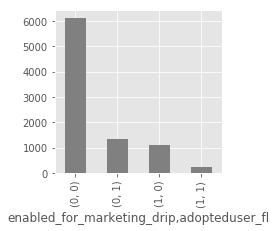

In [78]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['enabled_for_marketing_drip','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'enabled_for_marketing_drip', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

### Hypothesis5: Users who have affiliation to any organization have significantly different adoption pattern

org_id_fl  adopteduser_fl
0          0                 7004
           1                 1591
1          0                  217
           1                   11
dtype: int64


(27.083032400233851,
 1.9490114861853126e-07,
 1,
 array([[ 7034.39816389,   186.60183611],
        [ 1560.60183611,    41.39816389]]))

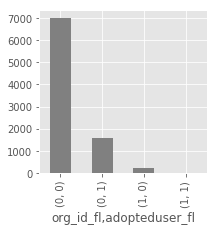

In [79]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['org_id_fl','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'org_id_fl', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

### Hypothesis6: Users from different creation source have significantly different adoption pattern

creation_source     adopteduser_fl
GUEST_INVITE        0                 1228
                    1                  360
ORG_INVITE          0                 2635
                    1                  553
PERSONAL_PROJECTS   0                  600
                    1                  164
SIGNUP              0                 1605
                    1                  293
SIGNUP_GOOGLE_AUTH  0                 1153
                    1                  232
dtype: int64


(40.094289640685048,
 4.1383652245208604e-08,
 4,
 array([[ 1299.66541993,  2609.15198912,   625.27983679,  1553.37844271,
          1133.52431146],
        [  288.33458007,   578.84801088,   138.72016321,   344.62155729,
           251.47568854]]))

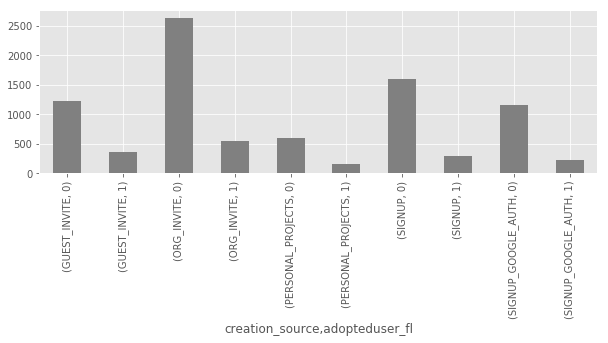

In [102]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['creation_source','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [10,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'creation_source', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

### Hypothesis7: Month in which user starts the engagement have significantly relation to their adoption pattern

month_fl  adopteduser_fl
1         0                 611
          1                 145
2         0                 578
          1                 134
3         0                 718
          1                 157
4         0                 761
          1                 106
5         0                 973
          1                  73
6         0                 455
          1                 150
7         0                 481
          1                 119
8         0                 503
          1                 141
9         0                 518
          1                 138
10        0                 541
          1                 160
11        0                 527
          1                 150
12        0                 555
          1                 129
dtype: int64


(155.81363245826566,
 9.6431510615244563e-28,
 11,
 array([[ 618.73240394,  582.72152329,  716.12546753,  709.57803468,
          856.07684461,  495.14960898,  491.05746345,  527.0683441 ,
          536.88949337,  573.71880313,  554.07650459,  559.80550833],
        [ 137.26759606,  129.27847671,  158.87453247,  157.42196532,
          189.92315539,  109.85039102,  108.94253655,  116.9316559 ,
          119.11050663,  127.28119687,  122.92349541,  124.19449167]]))

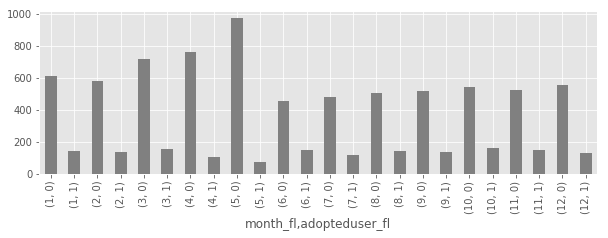

In [100]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['month_fl','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [10,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'month_fl', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

### Hypothesis8: Users having general purpose email domian ID's (gmal, yahoo and hotmail) have significantly different adoption pattern

non_generalpurpose_emaildomain  adopteduser_fl
0                               0                 4458
                                1                 1001
1                               0                 2763
                                1                  601
dtype: int64


(0.27990128022570981,
 0.59676592845483933,
 1,
 array([[ 4467.80448827,  2753.19551173],
        [  991.19551173,   610.80448827]]))

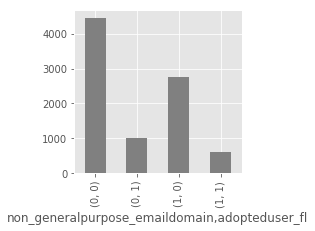

In [103]:
# Look at distribution wrt dependent
two_way_table_1 = master_data1.groupby(['non_generalpurpose_emaildomain','adopteduser_fl']).size()
print(two_way_table_1)

#plot 
plt.rcParams['figure.figsize'] = [3,3]
two_way_table_1.plot('bar',color = 'grey')

#chisquare independence test
chi2_contingency(
two_way_table_1.reset_index().pivot(columns = 'non_generalpurpose_emaildomain', 
                                    values=0,
                                    index = 'adopteduser_fl').values
)

## Build logistic regression

In [104]:
master_data1_1 = master_data1[['user_id_', 'weekssecondeng_count','firstweek_engcount','engagement_perweek',
                               'adopteduser_fl', 'creation_source','opted_in_to_mailing_list', 
                               'enabled_for_marketing_drip', 'org_id_fl','month_fl', 'non_generalpurpose_emaildomain']]

checking for distribution of numeric data across 2 classes

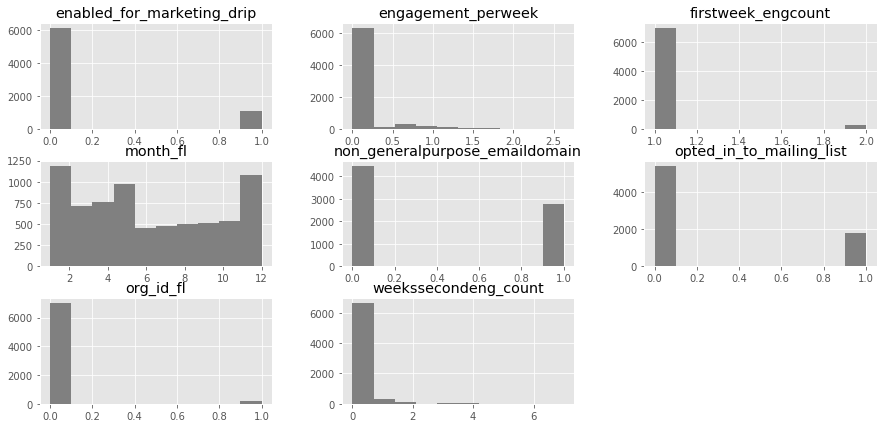

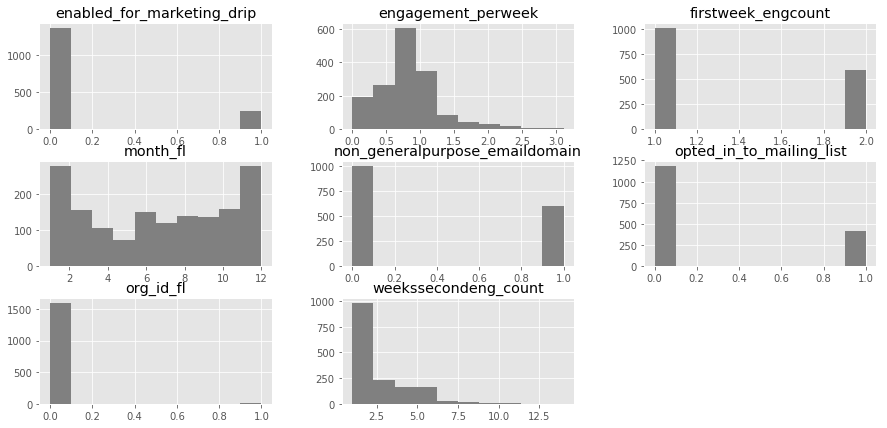

In [99]:
plt.rcParams['figure.figsize'] = [15, 7]
master_data1_1.groupby(['adopteduser_fl']).hist(color = 'grey')
plt.show()

Checking for discrete data distribution across 2 classes

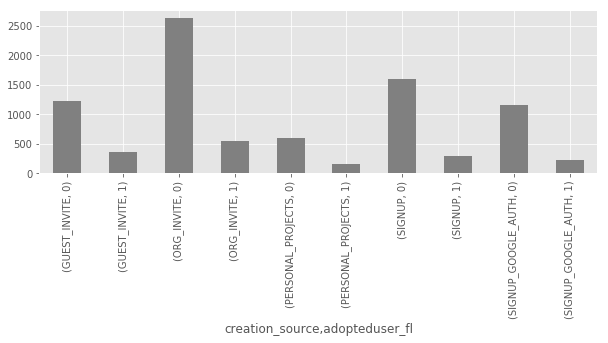

In [92]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10,3]
master_data1_1.groupby(['creation_source','adopteduser_fl']).size().plot('bar', color = 'grey' )
plt.show()

Do one hot encoding for all categorical variables

In [108]:
master_data2 = pd.get_dummies(master_data1_1, columns =['creation_source'])
master_data2.head()

,user_id_,weekssecondeng_count,firstweek_engcount,engagement_perweek,adopteduser_fl,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_fl,month_fl,non_generalpurpose_emaildomain,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0.0,1,0.000000,0,1,0,0,4,0,1,0,0,0,0
1,10,4.0,2,1.484848,1,1,1,0,1,1,0,1,0,0,0
2,100,0.0,1,0.000000,0,0,0,0,6,1,0,1,0,0,0
3,10000,1.0,2,0.000000,0,1,1,0,5,0,0,1,0,0,0
4,10002,2.0,2,0.617647,1,0,0,0,3,0,0,0,0,1,0


Check for correlation within variables using correlation matrix and VIF

In [109]:
master_data2.columns

Index(['user_id_', 'weekssecondeng_count', 'firstweek_engcount',
       'engagement_perweek', 'adopteduser_fl', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id_fl', 'month_fl',
       'non_generalpurpose_emaildomain', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

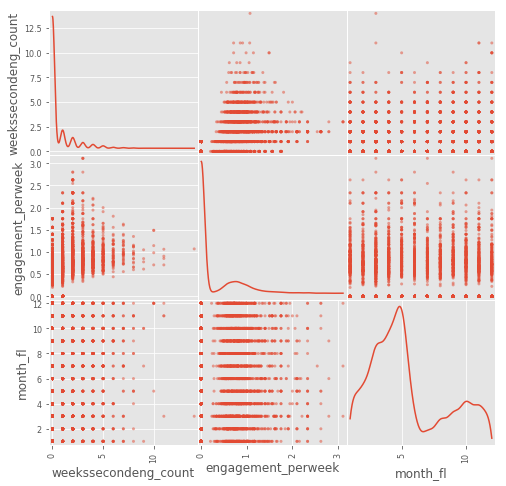

In [110]:
plt.rcParams['figure.figsize'] = [8,8]
scatter_matrix(master_data2[[ 'weekssecondeng_count','engagement_perweek','month_fl']], diagonal= 'kde')
plt.show()

In [111]:
corrmatrix = master_data2[['weekssecondeng_count','engagement_perweek','month_fl']].corr()
corrmatrix

,weekssecondeng_count,engagement_perweek,month_fl
weekssecondeng_count,1.000000,0.650548,0.044181
engagement_perweek,0.650548,1.000000,0.004000
month_fl,0.044181,0.004000,1.000000


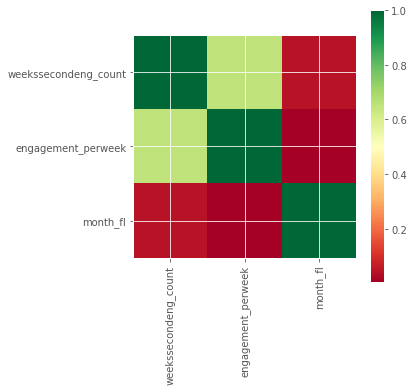

In [112]:
plt.rcParams['figure.figsize'] = (5,5)
plt.imshow(corrmatrix, cmap = 'RdYlGn')
plt.colorbar()
# plt.title('logins_count highly correlated with count_of_events, \n club_id_count,& quantity_sum')
plt.xticks(np.arange(corrmatrix.shape[0]),corrmatrix.columns, rotation = 90)
plt.yticks(np.arange(corrmatrix.shape[0]),corrmatrix.columns)
plt.show()

**Remove multicollinearity between variables using VIF and intuition from above scattermatrix and correlation matrix**

In [114]:
x_variables = ['weekssecondeng_count', 'firstweek_engcount',
       'engagement_perweek', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id_fl', 'month_fl',
       'non_generalpurpose_emaildomain']
vif=[variance_inflation_factor(np.array(master_data2[x_variables]),i)for i in np.arange(master_data2[x_variables].shape[1])]
pd.DataFrame({ 'x_variables': x_variables,'vif': vif }).sort_values('x_variables')

,vif,x_variables
4,1.547182,enabled_for_marketing_drip
2,2.287801,engagement_perweek
1,4.928161,firstweek_engcount
6,3.589102,month_fl
7,1.569549,non_generalpurpose_emaildomain
3,1.742972,opted_in_to_mailing_list
5,1.027289,org_id_fl
0,2.127945,weekssecondeng_count


In [115]:
x_variables = ['weekssecondeng_count', 'firstweek_engcount',
       'engagement_perweek', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id_fl',
       'non_generalpurpose_emaildomain']
vif=[variance_inflation_factor(np.array(master_data2[x_variables]),i)for i in np.arange(master_data2[x_variables].shape[1])]
pd.DataFrame({ 'x_variables': x_variables,'vif': vif }).sort_values('x_variables')

,vif,x_variables
4,1.546939,enabled_for_marketing_drip
2,2.278494,engagement_perweek
1,2.468557,firstweek_engcount
6,1.550081,non_generalpurpose_emaildomain
3,1.741284,opted_in_to_mailing_list
5,1.026679,org_id_fl
0,2.124754,weekssecondeng_count


**Final list of variables that will go into the model are**  
'weekssecondeng_count', 'firstweek_engcount',  
'engagement_perweek', 'opted_in_to_mailing_list',  
'enabled_for_marketing_drip', 'org_id_fl',  
'non_generalpurpose_emaildomain',  
'creation_source_GUEST_INVITE',  
'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',  
'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'  

#### Divide Data into training and testing dataset 

In [131]:
np.random.seed(123)
X= master_data2[['weekssecondeng_count', 'firstweek_engcount',
'engagement_perweek', 'opted_in_to_mailing_list',
'enabled_for_marketing_drip', 'org_id_fl',
'non_generalpurpose_emaildomain',
'creation_source_GUEST_INVITE',
'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']]

y = master_data2[['adopteduser_fl']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.30)

# Logistic regression

In [137]:
x_variables = [
'weekssecondeng_count', 
'firstweek_engcount',
'engagement_perweek', 
# 'opted_in_to_mailing_list',
# 'enabled_for_marketing_drip', 
# 'org_id_fl',
# 'non_generalpurpose_emaildomain',
# 'creation_source_GUEST_INVITE',
# 'creation_source_ORG_INVITE', 
# 'creation_source_PERSONAL_PROJECTS',
# 'creation_source_SIGNUP', 
# 'creation_source_SIGNUP_GOOGLE_AUTH'
               ]
X = sm.add_constant(X_train[x_variables])
model = sm.Logit(y_train['adopteduser_fl'],X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.219188
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         adopteduser_fl   No. Observations:                 6176
Model:                          Logit   Df Residuals:                     6172
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Apr 2018   Pseudo R-squ.:                  0.5373
Time:                        09:58:02   Log-Likelihood:                -1353.7
converged:                       True   LL-Null:                       -2925.4
                                        LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.9169      0.169    -23.245      0.000      -4.247      -3.587
weekssecondeng_count     1.6801      0.076     22.078      0.000       1.531       1.829
firstweek_engcount       0.5875      0.138      4.248      0.000       0.316       0.859
engagement_perweek       0.7366      0.124      5.930      0.000       0.493       0.980
========================================================================================
"""

In [138]:
X = sm.add_constant(X_test[x_variables])
ypredict = results.predict(X)
ypred = np.where(ypredict > .5,1,0)

print("Confusion Matrix")
print(confusion_matrix(ypred,y_test['adopteduser_fl'], labels = [1,0]))

print("\nF1-Score")
print(classification_report(ypred,y_test['adopteduser_fl']))

print("\nROC_AUC")
print(roc_auc_score(ypred,y_test['adopteduser_fl']))

print("\nAccuracy")
print(accuracy_score(ypred,y_test['adopteduser_fl']))

Confusion Matrix
[[ 295   75]
 [ 186 2091]]

F1-Score
             precision    recall  f1-score   support

          0       0.97      0.92      0.94      2277
          1       0.61      0.80      0.69       370

avg / total       0.92      0.90      0.91      2647


ROC_AUC
0.857805433892

Accuracy
0.90139780884


## Let us try simple XGboost 

### feature selection method using  scikit-learn

In [140]:
np.random.seed(2)
selector = SelectKBest(mutual_info_classif, k='all').fit(X_train, y_train['adopteduser_fl'].values)
score = selector.scores_ * 1000
featureselection_df = pd.DataFrame({'variable_name':X_train.columns,
            'var_info_score':score}).sort_values(by = ['var_info_score'], ascending = False)
featureselection_df

,var_info_score,variable_name
0,335.469528,weekssecondeng_count
2,233.293832,engagement_perweek
1,67.776391,firstweek_engcount
5,6.477955,org_id_fl
9,4.854249,creation_source_PERSONAL_PROJECTS
3,3.011696,opted_in_to_mailing_list
8,2.682080,creation_source_ORG_INVITE
11,0.747105,creation_source_SIGNUP_GOOGLE_AUTH
4,0.000000,enabled_for_marketing_drip
6,0.000000,non_generalpurpose_emaildomain


**All variables with var_info_score*1000 > 2.00 is considered to build XGBoost model **

In [141]:
selected_features = featureselection_df[featureselection_df['var_info_score'] > 2.0]['variable_name'].tolist()
selected_features
#get a high level model on all training data
model = XGBClassifier(max_depth=3, min_child_weight=5)
model.fit(X_train[selected_features], y_train['adopteduser_fl'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [142]:
y_pred = model.predict(X_test[selected_features])
predictions = [round(value) for value in y_pred]

print("Confusion Matrix")
print(confusion_matrix(y_test['adopteduser_fl'], predictions, labels = [1,0]))

print("\nF1-Score")
print(classification_report(y_test['adopteduser_fl'], predictions))

print("\nROC_AUC")
print(roc_auc_score(y_test['adopteduser_fl'], predictions))

print("\nAccuracy")
print(accuracy_score(y_test['adopteduser_fl'], predictions))

Confusion Matrix
[[ 476    5]
 [ 137 2029]]

F1-Score
             precision    recall  f1-score   support

          0       1.00      0.94      0.97      2166
          1       0.78      0.99      0.87       481

avg / total       0.96      0.95      0.95      2647


ROC_AUC
0.963177379382

Accuracy
0.94635436343
